# Quantitative Finance Model using Donadio and Ghosh Learn Algorithmic Trading Chapter 3 Support Vector Machine Example
### David Lowe
### August 16, 2022

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This script aims to replicate the Support Vector Machine example found in chapter three of the book Learn Algorithmic Trading by Sebastien Donadio and Sourav Ghosh. The script seeks to validate the Python environment and package requirements for running these code examples successfully. The eventual goal is to integrate various example code segments from the book into an end-to-end algorithmic trading system.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Sharadar US Equities and Fund Prices from Quandl/Nasdaq Data Link

Source and Further Discussion of the Code Examples: https://github.com/PacktPublishing/Learn-Algorithmic-Trading

# Task 1 - Prepare Environment

## 1.a) Load the required packages and modules

In [1]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## 1.b) Set up the controlling parameters and functions

In [2]:
# Specify the key modeling parameters below
DATA_STORE = '../sharadar.h5'
ticker_symbol = 'GOOGL'

MODEL_START_DATE = date(2012, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

# MODEL_END_DATE = datetime.now().date()
MODEL_END_DATE = date(2021, 12, 31)
print("Ending date for the model:", MODEL_END_DATE)

Starting date for the model: 2012-01-01
Ending date for the model: 2021-12-31


# Task 2 - Acquire and Pre-Process Data

## Instead of using pandas-datareader like in the book example, this script will use a home-grown data source.

In [3]:
with pd.HDFStore(DATA_STORE) as store:
    goog_data = (store['quandl/sharadar/sep'].loc[[ticker_symbol], ['open', 'high', 'low', 'close', 'volume']])
goog_data.reset_index(level=0, inplace=True)
goog_data.sort_index(inplace=True)
goog_data = goog_data[MODEL_START_DATE:MODEL_END_DATE]
goog_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2012-01-03 to 2021-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  2517 non-null   object 
 1   open    2517 non-null   float64
 2   high    2517 non-null   float64
 3   low     2517 non-null   float64
 4   close   2517 non-null   float64
 5   volume  2517 non-null   float64
dtypes: float64(5), object(1)
memory usage: 137.6+ KB


# Task 3 - Set up the Helper Functions for Modeling

In [4]:
def create_trading_condition(df):
    df['Open-Close'] = df.open - df.close
    df['High-Low'] = df.high - df.low
    df = df.dropna()
    features = df[['Open-Close','High-Low']]
    target = np.where(df['close'].shift(-1)>df['close'], 1, -1)
    return features, target

In [5]:
def create_train_split_group(features, target, split_ratio=0.8):
    split_value = int(split_ratio * len(goog_data))
    features_train = features[:split_value]
    target_train = target[:split_value]
    features_test = features[split_value:]
    target_test = target[split_value:]
    return features_train, features_test, target_train, target_test

In [6]:
def calculate_return(df, split_val, symbol):
    goog_return = df[split_val:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns'] = df['%s_Returns' % symbol] * df['Predicted_Signal'].shift(1)
    return goog_return

In [7]:
def calculate_strategy_return(df, split_val):
    strategy_return = df[split_val:]['Strategy_Returns'].cumsum() * 100
    return strategy_return

In [8]:
def plot_chart(cumu_symbol_return, cumu_strat_return, symbol):
    plt.figure(figsize=(16, 10))
    plt.plot(cumu_symbol_return, label='%s Returns' % symbol)
    plt.plot(cumu_strat_return, label='Strategy Returns')
    plt.legend()
    plt.show()

In [9]:
def sharpe_ratio(strategy_returns, symbol_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()

# Task 4 - Build model with the OLS algorithm

## This code segment implements and visualizes the OLS model.

In [10]:
X, Y = create_trading_condition(goog_data)

X_train, X_test, Y_train, Y_test = create_train_split_group(
    X, Y, split_ratio=0.8)

svc=SVC()
svc.fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, svc.predict(X_train))
accuracy_test = accuracy_score(Y_test, svc.predict(X_test))

print(accuracy_train, accuracy_test)

0.5355191256830601 0.4801587301587302


In [11]:
goog_data['Predicted_Signal'] = svc.predict(X)
goog_data['GOOGL_Returns'] = np.log(
    goog_data['close'] / goog_data['close'].shift(1))

print(goog_data.head())

           ticker    open    high     low   close       volume  Open-Close  \
date                                                                         
2012-01-03  GOOGL  16.340  16.720  16.326  16.652  146912000.0      -0.312   
2012-01-04  GOOGL  16.642  16.773  16.532  16.724  114444000.0      -0.082   
2012-01-05  GOOGL  16.570  16.616  16.422  16.492  131184000.0       0.078   
2012-01-06  GOOGL  16.495  16.517  16.261  16.267  107608000.0       0.228   
2012-01-09  GOOGL  16.179  16.191  15.546  15.577  232670000.0       0.602   

            High-Low  Predicted_Signal  GOOGL_Returns  
date                                                   
2012-01-03     0.394                 1            NaN  
2012-01-04     0.241                 1       0.004314  
2012-01-05     0.194                 1      -0.013969  
2012-01-06     0.256                 1      -0.013737  
2012-01-09     0.645                 1      -0.043343  


# Task 5 - Evaluate Model Performance

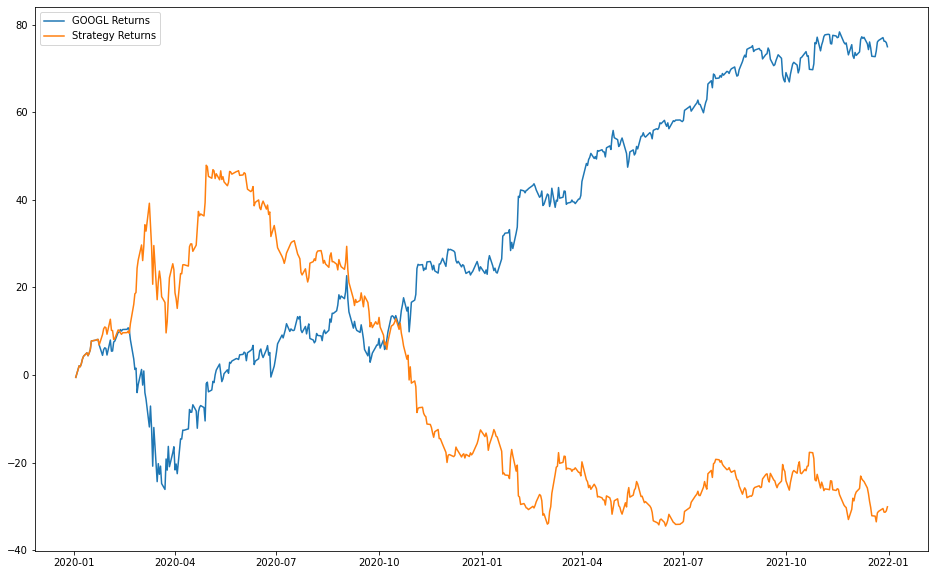

In [12]:
cumu_goog_return = calculate_return(
    goog_data, split_val=len(X_train), symbol=ticker_symbol)
cumu_strategy_return = calculate_strategy_return(
    goog_data, split_val=len(X_train))

plot_chart(cumu_goog_return, cumu_strategy_return, symbol=ticker_symbol)

In [13]:
print(sharpe_ratio(cumu_strategy_return, cumu_goog_return))

-1.4447280816004218
